## Demonstration of how Transport Velocity is a turbulence model

Setup based on https://mediatum.ub.tum.de/doc/1360487/978874575863.pdf

```bash
dx=0.015625  # 1/64
seed=123
# Generate initial relax particle configuration
python main.py config=cases/tgv.yaml case.mode=rlx solver.tvf=1.0 case.dim=2 case.dx=$dx \
  seed=$seed case.r0_noise_factor=0.25 io.data_path=data_relaxed/ eos.p_bg_factor=0.02

# Run reference SPH simulation
python main.py config=cases/tgv.yaml case.viscosity=0.0 case.dim=2 case.dx=$dx \
  io.write_every=100 case.state0_path=data_relaxed/tgv_2_${dx}_${seed}.h5 \
  solver.dt=0.00025 solver.t_end=10.0 case.special.num_vortices=8 \
  case.special.V0=0.8

# Run SPH with transport velocity
python main.py config=cases/tgv.yaml case.viscosity=0.0 case.dim=2 case.dx=$dx \
  io.write_every=100 case.state0_path=data_relaxed/tgv_2_${dx}_${seed}.h5 \
  solver.dt=0.00025 solver.t_end=10.0 case.special.num_vortices=8 \
  solver.tvf=1.0
```

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf

from jax_sph.io_state import read_h5
from jax_sph.utils import pos_init_cartesian_2d
from jax_sph.turbulence import mls_2nd_order, energy_spectrum

2025-01-15 00:52:22.634900: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.6.85). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


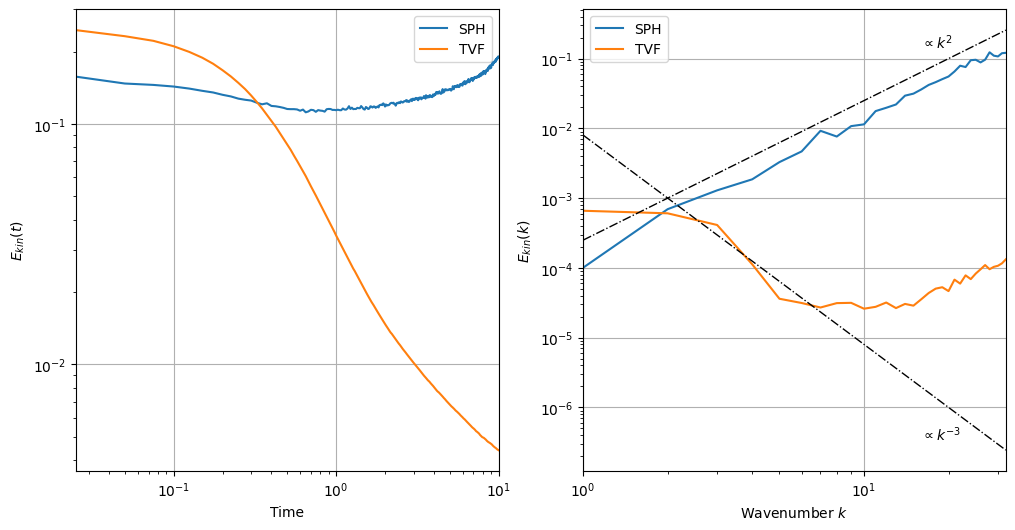

In [18]:
# Plot E_kin and energy spectra

source_paths = [
    '../data/debug/2D_TGV_SPH_123_20250115-000823',  # SPH
    '../data/debug/2D_TGV_SPH_123_20250114-235038',  # TVF
]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for data_root, label in zip(source_paths, ['SPH', 'TVF']):
    cfg = OmegaConf.load(os.path.join(data_root, "config.yaml"))
    files = os.listdir(data_root)
    files = [f for f in files if f.endswith('.h5')]
    files.sort()

    # Ekin
    e_kin = []
    for file in files:
        state = read_h5(os.path.join(data_root, file), array_type='numpy')
        e_kin.append((state['u']**2).sum())
    e_kin = 0.5 * np.array(e_kin)/cfg.case.num_particles_max
    x_axis = np.arange(len(e_kin))*cfg.solver.dt*cfg.io.write_every
    
    # Energy spectrum
    dim, dx = cfg.case.dim, cfg.case.dx
    N = cfg.case.num_particles_max
    nx = round(np.sqrt(N))
    k_axis = np.arange(1, nx//2+1)
    r, u = state['r'], state['u']  # last state of simulation
    box_size = np.array(cfg.case.bounds)[:, 1] - np.array(cfg.case.bounds)[:, 0]
    r_grid = pos_init_cartesian_2d(box_size, dx)
    u_mls = np.array([
        mls_2nd_order(r, r_grid, u[:,i], box_size, dx, dim, kernel_name="Quintic") for i in range(dim)
    ])
    spectrum = energy_spectrum(u_mls.reshape(dim, nx, nx))
    spectrum *= (1/(4 * np.pi))  # undo normalization to match magnitude from PDF above
    
    axs[0].plot(x_axis[1:], e_kin[1:], label=label)
    axs[1].plot(k_axis, spectrum[1:nx//2+1], label=label)


for ax in axs:
    ax.legend()
    ax.grid()
    ax.set_xscale('log')
    ax.set_yscale('log')

axs[0].set_xlabel(r'Time')
axs[0].set_ylabel(r'$E_{kin}(t)$')
axs[1].set_xlabel(r'Wavenumber $k$')
axs[1].set_ylabel(r'$E_{kin}(k)$')
axs[0].set_xlim((x_axis[1], x_axis[-1]))
axs[1].set_xlim((1, nx//2))

axs[1].plot(k_axis, 0.00025 * k_axis**(2.0), '-.', c='k', lw=1)
axs[1].plot(k_axis, 1/125 * k_axis**(-3.0), '-.', c='k', lw=1)
axs[1].text(0.8, 0.95, r"$\propto k^{2}$", ha='left', va='top', transform=ax.transAxes)
axs[1].text(0.8, 0.1, r"$\propto k^{-3}$", ha='left', va='top', transform=ax.transAxes)

plt.show()

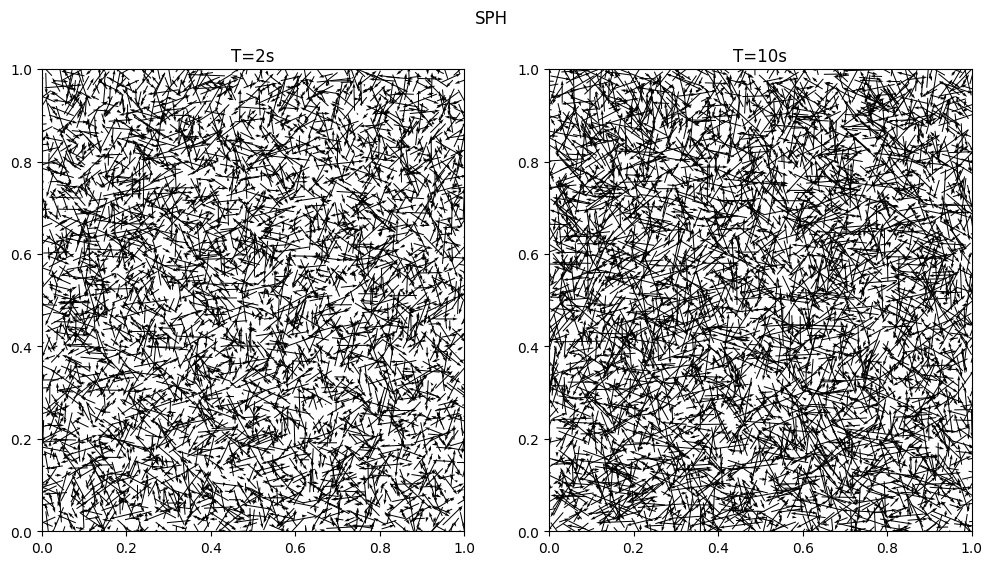

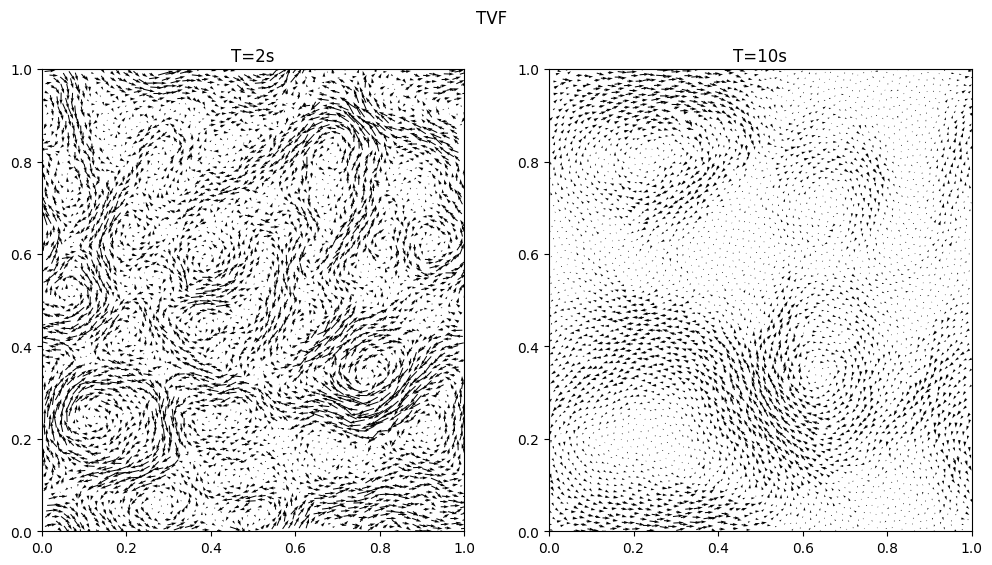

In [39]:
# Plot frames at times 2s and 10s

for data_root, suptitle in zip(source_paths, ['SPH', 'TVF']):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    plt.suptitle(suptitle)
    for ax, frame, title in zip(axs, ["08000", "40000"], ["T=2s", "T=10s"]):
        state_2s = read_h5(os.path.join(data_root, f"traj_{frame}.h5"), array_type='numpy')
        r, u = state_2s['r'], state_2s['u']

        ax.quiver(r[:,0], r[:,1], u[:,0], u[:,1], scale=10)
        ax.set_title(title)
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
    plt.show()